In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# edit

### **Download Datasets from Kaggle**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mnaufalazwar","key":"2e38845c5141e972406bdd7d6a19abbd"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d 'ahmetfurkandemr/mask-datasets-v1'
! mkdir GoogleBangkit
! unzip mask-datasets-v1.zip -d GoogleBangkit

 98% 737M/754M [00:16<00:00, 40.9MB/s]
100% 754M/754M [00:16<00:00, 48.6MB/s]
Archive:  mask-datasets-v1.zip
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/1.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/10.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/100.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/101.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/102.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/103.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/104.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/105.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/106.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/107.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/108.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/109.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/11.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/110.PNG  
  inflating: GoogleBangkit/

### **Define the Data Directory**

In [5]:
base_dir = '/content/GoogleBangkit/Mask_Datasets'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training Mask/No Mask pictures
train_Mask_dir = os.path.join(train_dir, 'Mask')
train_No_Mask_dir = os.path.join(train_dir, 'No_mask')

# Directory with our validation cat/dog pictures
validation_Mask_dir = os.path.join(validation_dir, 'Mask')
validation_No_Mask_dir = os.path.join(validation_dir, 'No_mask')

In [6]:
print('total training Mask images :', len(os.listdir(      train_Mask_dir ) ))
print('total training No Mask images :', len(os.listdir(      train_No_Mask_dir ) ))

print('total validation Mask images :', len(os.listdir( validation_Mask_dir ) ))
print('total validation No Mask images :', len(os.listdir( validation_No_Mask_dir ) ))

total training Mask images : 350
total training No Mask images : 400
total validation Mask images : 150
total validation No Mask images : 200


### **Image Visualization**

In [7]:
# Now, let's see what the filenames look like in the Mask and no mask train directories 
# (file naming conventions are the same in the validation directory)

train_Mask_fnames = os.listdir( train_Mask_dir )
train_No_Mask_fnames = os.listdir( train_No_Mask_dir )

print(train_Mask_fnames[:10])
print(train_No_Mask_fnames[:10])

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

['173.PNG', '67.PNG', '171.PNG', '255.PNG', '278.PNG', '344.PNG', '319.PNG', '294.PNG', '43.PNG', '35.PNG']
['Aaron_Patterson_0001.jpg', 'pmives.13.jpg', '15563.png', 'Juan_Carlos_Ferrero_0001.jpg', '15573.png', '15582.png', 'Juan_Carlos_Ferrero_0024.jpg', '15660.png', '15537.png', '15614.png']


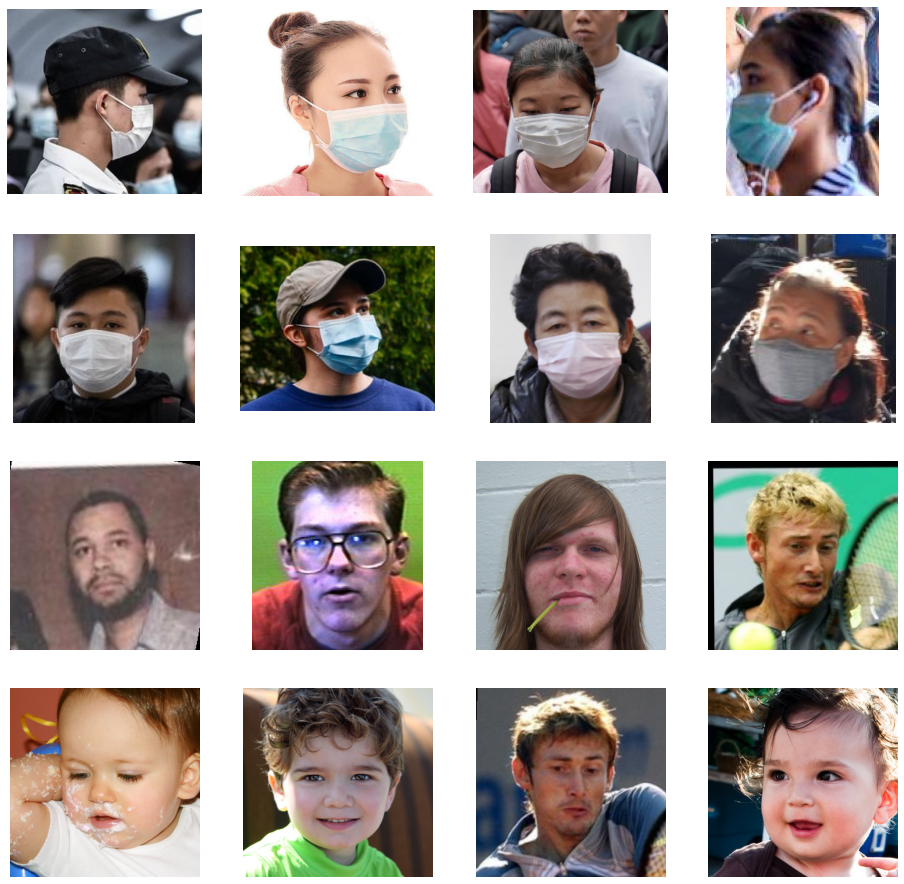

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Mask_pix = [os.path.join(train_Mask_dir, fname) 
                for fname in train_Mask_fnames[ pic_index-8:pic_index] 
               ]

next_No_Mask_pix = [os.path.join(train_No_Mask_dir, fname) 
                for fname in train_No_Mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Mask_pix+next_No_Mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### **3 LAYERS CNN MODEL**

In [ ]:
# DO NOT USE THIS MODEL FOR TRANSFER LEARNING

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Mask') and 1 for the other ('No_Mask')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [9]:
# USE THIS MODEL INSTEAD

IMAGE_SIZE = 224
dense = 2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
# ADD SOME LAYERS ABOVE BASE LAYER MODEL

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(dense, activation='softmax')
])
print('Base model ready')

Base model ready


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


### **Image Augmentation using ImageDataGenerator**

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# The ImageGenerator rescaling, rotate and do other operations.
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to IMAGE_SIZE
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      callbacks=[callbacks],
      verbose=2)

Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Epoch 1/50
38/38 - 35s - loss: 0.8425 - accuracy: 0.4987 - val_loss: 0.7050 - val_accuracy: 0.5229
Epoch 2/50
38/38 - 35s - loss: 0.6983 - accuracy: 0.4880 - val_loss: 0.6947 - val_accuracy: 0.4486
Epoch 3/50
38/38 - 34s - loss: 0.6937 - accuracy: 0.5213 - val_loss: 0.6934 - val_accuracy: 0.4457
Epoch 4/50
38/38 - 34s - loss: 0.6932 - accuracy: 0.4827 - val_loss: 0.6932 - val_accuracy: 0.4629
Epoch 5/50
38/38 - 34s - loss: 0.6932 - accuracy: 0.5253 - val_loss: 0.6932 - val_accuracy: 0.4314
Epoch 6/50
38/38 - 35s - loss: 0.6932 - accuracy: 0.4573 - val_loss: 0.6931 - val_accuracy: 0.4200
Epoch 7/50
38/38 - 35s - loss: 0.6931 - accuracy: 0.4893 - val_loss: 0.6931 - val_accuracy: 0.5143
Epoch 8/50
38/38 - 35s - loss: 0.6931 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.6000
Epoch 9/50
38/38 - 35s - loss: 0.6931 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.6286
Epoch 10/50
38/38 - 35s - l

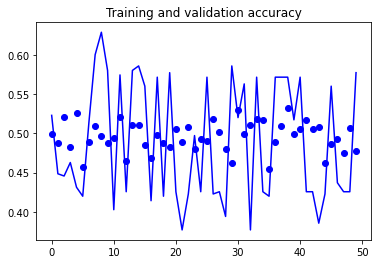

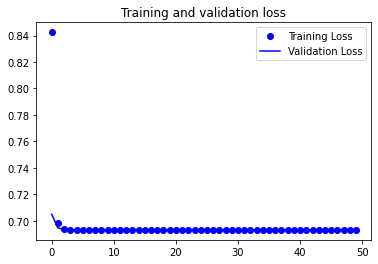

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Saved the model using tf.saved_model.save and then convert the saved model to a tf lite compatible format.

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
# Download the converted model and labels

from google.colab import files

files.download('model.tflite')